In [1]:
import os
import matplotlib.pyplot as plt
import umap.plot
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import math
import neuro_morpho_toolbox as nmt
import neuro_morpho_toolbox.plot as nmtp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import pickle
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

min_max_scaler = MinMaxScaler()
plt.style.use(['science', 'no-latex'])

def reassign_region_id():
    region_used=nmt.bs.selected_regions
    origin_ccf = np.array(nmt.annotation.array[:, :, :], dtype=np.uint32)
    selected_annotaion = np.zeros_like(nmt.annotation.array, dtype=np.uint32)
    for region in region_used:
        #get its child region
        child_regions = nmt.bs.get_all_child_id(region)
        if len(child_regions) == 0:
            ix, iy, iz = np.where(origin_ccf == region)
            selected_annotaion[ix, iy, iz] = region
            continue
        for childregion in child_regions:
            ix, iy, iz = np.where(origin_ccf == childregion)
            selected_annotaion[ix, iy, iz] = region
    print('processing finished, reassign region id to its parent_id')
    return selected_annotaion

def get_region_swc(cswc,
                   annotation=nmt.annotation,
                   brain_structure=nmt.bs,
                   region_used=None):
    tp = cswc.copy()
    tp = pd.DataFrame(
        {
            "x": np.array(np.array(tp.x),dtype="int32"),
            "y": np.array(np.array(tp.y),dtype="int32"),
            "z": np.array(np.array(tp.z),dtype="int32")
        },
        index=tp.index)
    tp = tp[((tp.x >= 0) & (tp.x < annotation.size['x']) & (tp.y >= 0) &
             (tp.y < annotation.size['y']) & (tp.z >= 0) &
             (tp.z < annotation.size['z']))]

    # Add region id to the dataframe
    if region_used is None:
        region_used = nmt.bs.selected_regions
        dict_to_used = nmt.bs.dict_to_selected
    else:
        assert all([
            (i in brain_structure.level.index.tolist()) for i in region_used
        ]), "Given regions invalid. Please check 'region_used'."
        dict_to_used = {}
        for cur_region in region_used:
            child_ids = nmt.bs.get_all_child_id(cur_region)
            for i in child_ids:
                dict_to_used[i] = cur_region
    tp["region_id"] = np.array(annotation.array[tp.x, tp.y, tp.z], dtype=int)
    tp = tp[tp.region_id.isin(list(dict_to_used.keys()))]
    tp["region_id"] = np.array(tp["region_id"].map(dict_to_used), dtype=int)
    res = cswc.copy()
    res['region_id'] = 0
    res.loc[tp.index, 'region_id'] = tp['region_id']
    return res

def get_soma_region(infile):
    inswc=nmt.swc.neuron(infile).swc
    rootnum=inswc[inswc.parent<0].shape[0]
    if rootnum != 1:
        print('Soma error: ', infile.split('/')[-1],' ; size= ', rootnum)
        return 'error'
    soma=inswc[inswc.parent<0].copy()
    soma['x']=soma['x']/25
    soma['y']=soma['y']/25
    soma['z']=soma['z']/25
    somar=get_region_swc(cswc=soma,annotation=my_annotation)
    soma_rid=somar['region_id'].tolist()[0]
    if soma_rid >0:
        return nmt.bs.id_to_name(soma_rid)
    return 'error'

ccf_reassigned_f='../ccf_reassigned.pickle'
if os.path.exists(ccf_reassigned_f):
    with open(ccf_reassigned_f,'rb') as f:
        my_annotation=pickle.load(f)
else:
    print('reassign start... will take a long time.')
    selected_annotaion=reassign_region_id()
    my_annotation=nmt.annotation
    my_annotation.array=selected_annotaion
    with open(ccf_reassigned_f,'wb') as f:
        pickle.dump(my_annotation,f)
# get cell type
r1741_type='/Users/jiangshengdian/Desktop/Daily/Reconstructions/seu_allen_data/1741_Celltype.csv'
r1741df=pd.read_csv(r1741_type,index_col=['name'])
swcdir='../motif/1780'
motif_dir='../motif/soma/soma_motif_csv'
celltype_new='../1780_cell_type.csv'
allpath=[]
for root,dirs,files in os.walk(motif_dir):
    for mfile in files:
        if os.path.splitext(mfile)[1] != '.csv':
            continue
        file_in=os.path.join(root,mfile)
        allpath.append(file_in)
fromFile=True
if fromFile and os.path.exists(celltype_new):
    validated_cells=pd.read_csv(celltype_new,index_col=['name'])
else:
    namelist=[]
    somalist=[]
    for findex,fpath in enumerate(allpath):
        fname=fpath.split('/')[-1]
        fbname=fname.split('.eswc')[0]
        namelist.append(fname)
        if fbname in r1741df.index:
            soma_region=r1741df.loc[fbname,'Soma_region']
        else:
            swcf=os.path.join(swcdir,fbname+'.eswc')
            soma_region=get_soma_region(swcf)
        somalist.append(soma_region)
    soma_region_df=pd.DataFrame({"name":namelist,"region":somalist})
    validated_cells=soma_region_df[(soma_region_df.region != 'error') & (soma_region_df.region != 'fiber tracts')].copy()
    validated_cells.set_index(['name'],inplace=True)
    validated_cells.to_csv(celltype_new)
# print(validated_cells.value_counts().head(10))

/Users/jiangshengdian/opt/anaconda3/envs/py37/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.72
Loading CCF brain structure data...
Loading time: 0.01
Loading flat_map ...
Loading time: 6.94


In [2]:
# soma branching plot
from scipy import misc
from PIL import Image
from libtiff import TIFF

figcenter='./soma_motif_figs/'

def tiff_to_image_array(tiff_image_name, out_folder, out_type):

    tif = TIFF.open(tiff_image_name, mode="r")
    idx = 0
    for im in list(tif.iter_images()):
        im_name = out_folder + str(idx) + out_type
        misc.imsave(im_name, im)
        print(im_name, 'successfully saved!!!')
        idx = idx + 1
    return
def Img2TIFF(infile,compression=None):
    #get imgpath and img_basename
    inimgname = infile.split('/')[-1]
    inimgbasename = inimgname.split('.')[0]
    imgpath = infile.split(inimgbasename)[0]
    outfile = imgpath + inimgbasename + '.tiff'
    out_tiff = TIFF.open(outfile, mode='w')
    in_image_array = Image.open(infile)
    # img = in_image_array.resize((480, 480), Image.ANTIALIAS)
    out_tiff.write_image(in_image_array, compression=compression, write_rgb=True)
    out_tiff.close()
    print('save tiff :', outfile)
    return
def get_degree(tswc):
    tswc['degree'] = tswc['parent'].isin(tswc.index).astype('int')
    # print(tswc['degree'])
    n_child = tswc.parent.value_counts()
    n_child = n_child[n_child.index.isin(tswc.index)]
    tswc.loc[n_child.index, 'degree'] = tswc.loc[n_child.index, 'degree'] + n_child
    return tswc
def get_rid(swc):
    '''
    Find root node.
    '''
    rnode=swc[((swc['parent']<0) & (swc['type']<=1))]
    if rnode.shape[0]<1:
        return -1
    return rnode.index[0]
def get_keypoint(swc, rid=None):
    if rid is None:
        rid = get_rid(swc)
    #print(swc.shape)
    swc=get_degree(swc)
    idlist = swc[((swc.degree!=2) | (swc.index==rid))].index.tolist()
    return idlist
def swc2branches(swc):
    '''
    reture branch list of a swc
    '''
    keyids=get_keypoint(swc)
    branches=[]
    for key in keyids:
        if swc.loc[key,'parent']<0 | swc.loc[key,'type']<=1:
            continue
        branch=[]
        branch.append(key)
        pkey=swc.loc[key,'parent']
        while True:
            branch.append(pkey)
            if pkey in keyids:
                break
            key=pkey
            pkey=swc.loc[key,'parent']
        branches.append(branch)
    return branches
def swc_plot(file,direction='XY',title=None,linewidth=2,shift=True,xlim=None,ylim=None):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    colors=['white','black','red','blue','magenta','yellow']
    swc=nmt.swc.neuron(file).swc
    if shift:
        swc.loc[:,'x']-=swc.loc[:,'x'].min()
        swc.loc[:,'y']-=swc.loc[:,'y'].min()
        swc.loc[:,'z']-=swc.loc[:,'z'].min()
    swc_brs=swc2branches(swc)
    for br in swc_brs:
        br_color=colors[int(swc.loc[br[0],'type'])]
        br_coords=swc.loc[br,['x','y','z']].copy()
        Xe=br_coords['x'].to_list()
        Ye=br_coords['y'].to_list()
        Ze=br_coords['z'].to_list()
        if direction=='YZ':
            ax.plot(Ye, Ze, c=br_color,linewidth=linewidth)
            ax.set_xlabel('Y',fontsize=10)
            ax.set_ylabel('Z',fontsize=10) 
        elif direction=='XZ':
            ax.plot(Xe, Ze, c=br_color,linewidth=linewidth)
            ax.set_xlabel('X',fontsize=10)
            ax.set_ylabel('Z',fontsize=10) 
        else:
            ax.plot(Xe, Ye, c=br_color,linewidth=linewidth)
            ax.set_xlabel('X',fontsize=10)
            ax.set_ylabel('Y',fontsize=10)
    if title is not None:
        ax.set_title(title,fontsize=12)
    if xlim is not None:
        ax.set_xlim(xlim) 
    if ylim is not None:
        ax.set_ylim(ylim)      
    return fig, ax
def motifs_plot(files,direction='XY',title=None,linewidth=2,shift=True,fontsize=12,compare=0,colorful=True
                ,xylabel=True,markersize=14):
    '''compare==0: max
    compare!=0: with the compare size
    '''
    fsize=len(files)
    basic_width=5
    colors=['black','black','black','black','black','black']
    if colorful:
        colors=['white','black','red','blue','magenta','yellow']
        # colors=['white','black','red','blue','green','yellow']
    fig, cax = plt.subplots(1,fsize, figsize=(fsize*basic_width,basic_width),dpi=100)
    xmax=0
    ymax=0
    zmax=0
    swcs=[]
    for file in files:
        swc=nmt.swc.neuron(file).swc
        if shift:
            swc.loc[:,'x']-=swc.loc[:,'x'].min()
            swc.loc[:,'y']-=swc.loc[:,'y'].min()
            swc.loc[:,'z']-=swc.loc[:,'z'].min()
        xmax=swc.loc[:,'x'].max() if swc.loc[:,'x'].max() > xmax else xmax
        ymax=swc.loc[:,'y'].max() if swc.loc[:,'y'].max() > ymax else ymax
        zmax=swc.loc[:,'z'].max() if swc.loc[:,'z'].max() > zmax else zmax
        swcs.append(swc) 
    for i,swc in enumerate(swcs):
        ax = cax[i]
        ax.tick_params(labelsize=fontsize)
        # swc=nmt.swc.neuron(file).swc
        swc_brs=swc2branches(swc)
        for br in swc_brs:
            br_color=colors[int(swc.loc[br[0],'type'])]
            br_coords=swc.loc[br,['x','y','z']].copy()
            Xe=br_coords['x'].to_list()
            Ye=br_coords['y'].to_list()
            Ze=br_coords['z'].to_list()
            if direction=='YZ':
                ax.plot(Ye, Ze, c=br_color,linewidth=linewidth)
                xamax=ymax
                yamax=zmax
                xlabel_text='Y'
                ylabel_text='Z'
            elif direction=='XZ':
                ax.plot(Xe, Ze, c=br_color,linewidth=linewidth)
                xamax=xmax
                yamax=zmax
                xlabel_text='X'
                ylabel_text='Z'
            else:
                ax.plot(Xe, Ye, c=br_color,linewidth=linewidth)
                xamax=xmax
                yamax=ymax
                xlabel_text='X'
                ylabel_text='Y'
        hid=get_rid(swc)
        if hid is not None:
            head_coord=swc.loc[hid,['x','y','z']].copy()
            if direction=='YZ':
                ax.plot(head_coord['y'], head_coord['z'], c='black',marker='o',markersize=markersize)
            elif direction=='XZ':
                ax.plot(head_coord['x'], head_coord['z'], c='black',marker='o',markersize=markersize)
            else:
                ax.plot(head_coord['x'], head_coord['y'], c='black',marker='o',markersize=markersize)
        if compare==0:
            ax.set_xlim([0,xamax])
            ax.set_ylim([0,yamax])
        elif compare >0:
            ax.set_xlim([0,compare])
            ax.set_ylim([0,compare])
        if xylabel:

            ax.set_xlabel(xlabel_text,fontsize=fontsize)
            ax.set_ylabel(ylabel_text,fontsize=fontsize)
        else:
            ax.set_xlabel('')
            ax.set_ylabel('')
        # ax.set_xticklabels(fontsize=10)
        # ax.set_yticklabels(fontsize=10)
        # axes=plt.gca()
        # axes.xaxis.label.set_size(fontsize)
        # axes.yaxis.label.set_size(fontsize)
        if title is not None:
            ax.set_title(title[i],fontsize=fontsize)
        # ax.tick_params(labelsize=fontsize)
        
    plt.tight_layout()
    return fig, cax
def acos(invalue):
    return math.acos(invalue)*180/math.pi

In [158]:
###old version of feature extraction
fea_names=['stems','stems_axon','stems_baselden','stems_apicalden',
            'stems_axon_len','stems_baselden_len','stems_apicalden_len',
            'stems_axon_plen','stems_baselden_plen','stems_apicalden_plen',
            'stems_axon_contraction','stems_baselden_contraction','stems_apicalden_contraction',
            'len_min','len_max','len_mean','len_median','len_std',
            'plen_min','plen_max','plen_mean','plen_median','plen_std',
            'width','height','depth','contraction_mean',
            'r_min','r_max','r_mean','r_median','r_std',
            'angle_min','angle_max','angle_mean','angle_median','angle_std',
            'angler_min','angler_max','angler_mean','angler_median','angler_std','region']

def read_soma_data(file):
    '''
    1. ['id','type','length','pathlength','radius','width','height','depth']
    2. near angle to other stems and remote angle to other stems
    '''
    h1=['id','type','length','pathlength','radius','width','height','depth']
    somadf=pd.read_csv(file,skiprows=[0],header=None)
    somaraw=somadf.loc[:,np.arange(0,len(h1))].copy()
    somaraw.columns=h1
    stems=somaraw.shape[0]
    stems_axon=somaraw[somaraw.type==2].shape[0]
    stems_baselden=somaraw[somaraw.type==3].shape[0]
    stems_apicalden=somaraw[somaraw.type==4].shape[0]
    stems_axon_len=0
    stems_baselden_len=0
    stems_apicalden_len=0
    stems_axon_plen=0
    stems_baselden_plen=0
    stems_apicalden_plen=0
    stems_axon_contraction=1
    stems_baselden_contraction=1
    stems_apicalden_contraction=1
    if stems_axon>0:
        stems_axon_len=somaraw[somaraw.type==2]['length'].mean()
        stems_axon_plen=somaraw[somaraw.type==2]['pathlength'].mean()
        stems_axon_contraction=stems_axon_len/stems_axon_plen
    if stems_baselden>0:
        stems_baselden_len=somaraw[somaraw.type==3]['length'].mean()
        stems_baselden_plen=somaraw[somaraw.type==3]['pathlength'].mean()
        stems_baselden_contraction=stems_baselden_len/stems_baselden_plen
    if stems_apicalden >0:
        stems_apicalden_len=somaraw[somaraw.type==4]['length'].mean()
        stems_apicalden_plen=somaraw[somaraw.type==4]['pathlength'].mean()
        stems_apicalden_contraction=stems_apicalden_len/stems_apicalden_plen
    len_min=somaraw['length'].min()
    len_max=somaraw['length'].max()
    len_mean=somaraw['length'].mean()
    len_median=somaraw['length'].median()
    len_std=somaraw['length'].std()
    plen_min=somaraw['pathlength'].min()
    plen_max=somaraw['pathlength'].max()
    plen_mean=somaraw['pathlength'].mean()
    plen_median=somaraw['pathlength'].median()
    plen_std=somaraw['pathlength'].std()
    width=somaraw['width'].mean()
    height=somaraw['height'].mean()
    depth=somaraw['depth'].mean()
    contraction_mean=len_mean/plen_mean
    r_min=somaraw['radius'].min()
    r_max=somaraw['radius'].max()
    r_mean=somaraw['radius'].mean()
    r_median=somaraw['radius'].median()
    r_std=somaraw['radius'].std()

    angles=somadf.loc[:,np.arange(len(h1),somadf.shape[1])].applymap(acos).copy()
    near_angles=angles.loc[:,len(h1):(len(h1)+somaraw.shape[0]-1)].copy()
    angle_max=near_angles.max().mean()
    angle_min=near_angles[near_angles>0].min().mean()
    angle_mean=near_angles.mean().mean()
    angle_median=near_angles.median().mean()
    angle_std=near_angles.std().mean()
    remote_angles=angles.loc[:,(len(h1)+somaraw.shape[0]):].copy()
    angler_max=remote_angles.max().mean()
    angler_min=remote_angles[remote_angles>0].min().mean()
    angler_mean=remote_angles.mean().mean()
    angler_median=remote_angles.median().mean()
    angler_std=remote_angles.std().mean()

    return [stems,stems_axon,stems_baselden,stems_apicalden,
            stems_axon_len,stems_baselden_len,stems_apicalden_len,
            stems_axon_plen,stems_baselden_plen,stems_apicalden_plen,
            stems_axon_contraction,stems_baselden_contraction,stems_apicalden_contraction,
            len_min,len_max,len_mean,len_median,len_std,
            plen_min,plen_max,plen_mean,plen_median,plen_std,
            width,height,depth,contraction_mean,
            r_min,r_max,r_mean,r_median,r_std,
            angle_min,angle_max,angle_mean,angle_median,angle_std,
            angler_min,angler_max,angler_mean,angler_median,angler_std]
def read_soma_data_v2(file):
    '''
    1. ['id','type','length','pathlength','radius','width','height','depth']
    2. near angle to other stems and remote angle to other stems
    '''
    h1=['id','type','length','pathlength','radius','width','height','depth']
    somadf=pd.read_csv(file,skiprows=[0],header=None)
    somaraw=somadf.loc[:,np.arange(0,len(h1))].copy()
    somaraw.columns=h1
    stems=somaraw.shape[0]
    stems_axon=somaraw[somaraw.type==2].shape[0]
    stems_baselden=somaraw[somaraw.type==3].shape[0]
    stems_apicalden=somaraw[somaraw.type==4].shape[0]
    stems_axon_len=0
    stems_baselden_len=0
    stems_apicalden_len=0
    stems_axon_plen=0
    stems_baselden_plen=0
    stems_apicalden_plen=0
    stems_axon_contraction=1
    stems_baselden_contraction=1
    stems_apicalden_contraction=1
    if stems_axon>0:
        stems_axon_len=somaraw[somaraw.type==2]['length'].mean()
        stems_axon_plen=somaraw[somaraw.type==2]['pathlength'].mean()
        stems_axon_contraction=stems_axon_len/stems_axon_plen
    if stems_baselden>0:
        stems_baselden_len=somaraw[somaraw.type==3]['length'].mean()
        stems_baselden_plen=somaraw[somaraw.type==3]['pathlength'].mean()
        stems_baselden_contraction=stems_baselden_len/stems_baselden_plen
    if stems_apicalden >0:
        stems_apicalden_len=somaraw[somaraw.type==4]['length'].mean()
        stems_apicalden_plen=somaraw[somaraw.type==4]['pathlength'].mean()
        stems_apicalden_contraction=stems_apicalden_len/stems_apicalden_plen
    len_min=somaraw['length'].min()
    len_max=somaraw['length'].max()
    len_mean=somaraw['length'].mean()
    len_median=somaraw['length'].median()
    len_std=somaraw['length'].std()
    plen_min=somaraw['pathlength'].min()
    plen_max=somaraw['pathlength'].max()
    plen_mean=somaraw['pathlength'].mean()
    plen_median=somaraw['pathlength'].median()
    plen_std=somaraw['pathlength'].std()
    width=somaraw['width'].mean()
    height=somaraw['height'].mean()
    depth=somaraw['depth'].mean()
    contraction_mean=len_mean/plen_mean
    r_min=somaraw['radius'].min()
    r_max=somaraw['radius'].max()
    r_mean=somaraw['radius'].mean()
    r_median=somaraw['radius'].median()
    r_std=somaraw['radius'].std()

    angles=somadf.loc[:,np.arange(len(h1),somadf.shape[1])].applymap(acos).copy()
    hist_angles_local=[]
    hist_angles_remote=[]
    for i in np.arange(0,len(angles.index)):
        for j in np.arange(len(h1),(len(h1)+somaraw.shape[0]-1)):
            if i<= j-len(h1):
                continue
            hist_angles_local.append(angles.iloc[i][j])
        for j in np.arange((len(h1)+somaraw.shape[0]),len(h1)+angles.shape[1]+1):
            if i<= j-(len(h1)+somaraw.shape[0]):
                continue
            hist_angles_remote.append(angles.iloc[i][j])
    
    angle_max=np.max(hist_angles_local)
    angle_min=np.min(hist_angles_local)
    angle_mean=np.mean(hist_angles_local)
    angle_median=np.median(hist_angles_local)
    angle_std=np.std(hist_angles_local)
    
    angler_max=np.max(hist_angles_remote)
    angler_min=np.min(hist_angles_remote)
    angler_mean=np.mean(hist_angles_remote)
    angler_median=np.median(hist_angles_remote)
    angler_std=np.std(hist_angles_remote)

    return [stems,stems_axon,stems_baselden,stems_apicalden,
            stems_axon_len,stems_baselden_len,stems_apicalden_len,
            stems_axon_plen,stems_baselden_plen,stems_apicalden_plen,
            stems_axon_contraction,stems_baselden_contraction,stems_apicalden_contraction,
            len_min,len_max,len_mean,len_median,len_std,
            plen_min,plen_max,plen_mean,plen_median,plen_std,
            width,height,depth,contraction_mean,
            r_min,r_max,r_mean,r_median,r_std,
            angle_min,angle_max,angle_mean,angle_median,angle_std,
            angler_min,angler_max,angler_mean,angler_median,angler_std]

# sf='../motif/soma/soma_motif_csv/236174_5338_x13590_y7348.csv'
# sfdf=read_soma_data(sf)
#get soma branching motif
soma_motifs='../soma_motifs.csv'
fromFile=True
if fromFile and os.path.exists(soma_motifs):
    smotifs=pd.read_csv(soma_motifs,index_col=['name'])
else:
    smotifs=pd.DataFrame(columns=fea_names)
    for findex,fpath in enumerate(allpath):
        fname=fpath.split('/')[-1]
        findex=fname.split('.cs')[0]+'.eswc.csv'
        sfeas=read_soma_data_v2(fpath)
        # print(sfeas)
        for fi,fea in enumerate(fea_names):
            # print(sfeas[fi],findex,fea)
            if fea == 'region':
                if findex in validated_cells.index:
                    smotifs.loc[findex,fea]=validated_cells.loc[findex,fea]
                else:
                    smotifs.loc[findex,fea]='Unknown'
            else:
                smotifs.loc[findex,fea]=float(sfeas[fi])
    smotifs.index.name='name'
    smotifs=smotifs[smotifs.region!='Unknown']
    smotifs.dropna(inplace=True)
    smotifs.to_csv(soma_motifs)
# smotifs.keys()

In [5]:

angle_step=45
fea_names=['stems','stems_axon','stems_baselden','stems_apicalden',
            'stems_axon_len','stems_baselden_len','stems_apicalden_len',
            'stems_axon_plen','stems_baselden_plen','stems_apicalden_plen',
            'width','height','depth',
            'len_mean','len_std','len_min','len_max',
            'plen_mean','plen_std','plen_min','plen_max',
            'angle_mean','angle_std','angle_min','angle_max',
            'angle_remote_mean','angle_remote_std','angle_remote_min','angle_remote_max',
            'region']

def read_soma_data_v3(file,angle_step=10):
    '''histgram of angle features
    '''
    h1=['id','type','length','pathlength','radius','width','height','depth']
    somadf=pd.read_csv(file,skiprows=[0],header=None)
    somaraw=somadf.loc[:,np.arange(0,len(h1))].copy()
    somaraw.columns=h1
    stems=somaraw.shape[0]
    stems_axon=somaraw[somaraw.type==2].shape[0]
    stems_baselden=somaraw[somaraw.type==3].shape[0]
    stems_apicalden=somaraw[somaraw.type==4].shape[0]
    stems_axon_len=0
    stems_baselden_len=0
    stems_apicalden_len=0
    stems_axon_plen=0
    stems_baselden_plen=0
    stems_apicalden_plen=0
    if stems_axon>0:
        stems_axon_len=somaraw[somaraw.type==2]['length'].mean()
        stems_axon_plen=somaraw[somaraw.type==2]['pathlength'].mean()
    if stems_baselden>0:
        stems_baselden_len=somaraw[somaraw.type==3]['length'].mean()
        stems_baselden_plen=somaraw[somaraw.type==3]['pathlength'].mean()
    if stems_apicalden >0:
        stems_apicalden_len=somaraw[somaraw.type==4]['length'].mean()
        stems_apicalden_plen=somaraw[somaraw.type==4]['pathlength'].mean()

    stem_type_fea=[stems_axon,stems_baselden,stems_apicalden,
            stems_axon_len,stems_baselden_len,stems_apicalden_len,
            stems_axon_plen,stems_baselden_plen,stems_apicalden_plen]
    width=somaraw['width'].mean()
    height=somaraw['height'].mean()
    depth=somaraw['depth'].mean()
    # somaraw['contraction']=somaraw['length']/somaraw['pathlength']
    #length,path length and radius histogram
    lenfea=somaraw.describe()['length'].tolist()[1:4]
    lenfea.append(somaraw.describe()['length'].tolist()[-1])
    plenfea=somaraw.describe()['pathlength'].tolist()[1:4]
    plenfea.append(somaraw.describe()['pathlength'].tolist()[-1])
    # rfea=somaraw.describe()['radius'].tolist()[1:4]
    # cfea=somaraw.describe()['contraction'].tolist()[1:4]
    angles=somadf.loc[:,np.arange(len(h1),somadf.shape[1])].applymap(acos).copy()
    if angles.shape[0] > angles.dropna().shape[0] or stems <=2:
        return None
    hist_angles_local=[]
    hist_angles_remote=[]
    for i in np.arange(0,len(angles.index)):
        for j in np.arange(len(h1),(len(h1)+somaraw.shape[0]-1)):
            if i<= j-len(h1):
                continue
            hist_angles_local.append(angles.iloc[i][j])
        for j in np.arange((len(h1)+somaraw.shape[0]),len(h1)+angles.shape[1]+1):
            if i<= j-(len(h1)+somaraw.shape[0]):
                continue
            hist_angles_remote.append(angles.iloc[i][j])
        
    # local_angles=np.zeros(int(180/angle_step))
    # for angle in hist_angles_local:
    #     angle=(angle-1) if angle==180 else angle
    #     aindex=math.floor(angle/angle_step)
    #     local_angles[aindex]+=1
    # remote_angles=np.zeros(int(180/angle_step))
    # for angle in hist_angles_remote:
    #     angle=(angle-1) if angle==180 else angle
    #     aindex=math.floor(angle/angle_step)
    #     remote_angles[aindex]+=1
    
    angle_max=np.max(hist_angles_local)
    angle_min=np.min(hist_angles_local)
    angle_mean=np.mean(hist_angles_local)
    # angle_median=np.median(hist_angles_local)
    angle_std=np.std(hist_angles_local)
    local_angles=[angle_mean,angle_std,angle_min,angle_max]
    
    angler_max=np.max(hist_angles_remote)
    angler_min=np.min(hist_angles_remote)
    angler_mean=np.mean(hist_angles_remote)
    # angler_median=np.median(hist_angles_remote)
    angler_std=np.std(hist_angles_remote)
    remote_angles=[angler_mean,angler_std,angler_min,angler_max]
    outfea=[stems]+stem_type_fea+[width,height,depth]
    outfea+=(lenfea+plenfea+local_angles+remote_angles)
    return outfea
soma_motifs='../soma_motifs.csv'
fromFile=True
if fromFile and os.path.exists(soma_motifs):
    smotifs=pd.read_csv(soma_motifs,index_col=['name'])
else:
    smotifs=pd.DataFrame(columns=fea_names)
    for findex,fpath in enumerate(allpath):
        fname=fpath.split('/')[-1]
        findex=fname.split('.cs')[0]+'.eswc.csv'
        # print(fname) 
        sfeas=read_soma_data_v3(fpath,angle_step=angle_step)
        if sfeas is None:
            print('skip: ',fname)
            continue
        # print(sfeas)
        for fi,fea in enumerate(fea_names):
            # print(sfeas[fi],findex,fea)
            if fea == 'region':
                if findex in validated_cells.index:
                    smotifs.loc[findex,fea]=validated_cells.loc[findex,fea]
                else:
                    smotifs.loc[findex,fea]='Unknown'
            else:
                smotifs.loc[findex,fea]=float(sfeas[fi])
    smotifs.index.name='name'
    smotifs=smotifs[smotifs.region!='Unknown']
    smotifs.dropna(inplace=True)
    smotifs.to_csv(soma_motifs)

In [ ]:
#Debug#
sf='../motif/soma/soma_motif_csv/18455_00109.csv'

h1=['id','type','length','pathlength','radius','width','height','depth']
somadf=pd.read_csv(sf,skiprows=[0],header=None)
somaraw=somadf.loc[:,np.arange(0,len(h1))].copy()
somaraw.columns=h1

In [178]:
# angle pca
a_feas_file='../angle_distribution_feas.csv'
if os.path.exists(a_feas_file):
    a_feas=pd.read_csv(a_feas_file,index_col=['name'])

smotifs=pd.concat([smotifs,a_feas],axis=1)
smotifs.dropna(inplace=True)

In [160]:
#get centroid features
centroid_file='../soma_centroid_fea.csv'
if os.path.exists(centroid_file):
    centroids=pd.read_csv(centroid_file,index_col=['name'])
#merge with smotifs
smotifs=pd.concat([smotifs,centroids],axis=1)
smotifs.dropna(inplace=True)

In [5]:
smotifs.keys()

Index(['stems', 'stems_axon', 'stems_baselden', 'stems_apicalden',
       'stems_axon_len', 'stems_baselden_len', 'stems_apicalden_len',
       'stems_axon_plen', 'stems_baselden_plen', 'stems_apicalden_plen',
       'width', 'height', 'depth', 'len_mean', 'len_std', 'len_min', 'len_max',
       'plen_mean', 'plen_std', 'plen_min', 'plen_max', 'angle_mean',
       'angle_std', 'angle_min', 'angle_max', 'angle_remote_mean',
       'angle_remote_std', 'angle_remote_min', 'angle_remote_max', 'region',
       'brain_region'],
      dtype='object')

In [4]:
# # brain region
# striatum_regions=['CP']
# # thalamus_regions=['VPM','VPL','LGd','MG','MD','SMT','PO','LD','LP']
# #cortex
# cortex_regions=['MOp','MOs','SSp-m','SSp-bfd','SSs','CLA']
# # thalamus
# Th_core_type = ['VPM', 'VPL', 'VPMpc', 'VPLpc', 'LGd', 'MG', 'VAL', 'AM', 'SMT']
# Th_matrix_type = ['LP', 'PO', 'LD', 'VM', 'RE', 'CM', 'IAD', 'PVT']
TH=['AD','AM','AV','CL','CM','IAD','LD','LGd','LHA','LP','MD','MG','MM','PCN','PF','PIL','PO','POL','PR','PVT',
   'PoT','RE','RT','SGN','SMT','SSp','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-tr','SSp-ul','SSp-un','TH','VAL','VM',
   'VPL','VPLpc','VPM','VPMpc']
CTX=['ACAd','ACAv','AId','AIp','AIv','AON','AON','AUDd','AUDpo','AUDv','BLA','BMA','CA1','CA3','CLA','COAp','HPF','DG',
    'ECT','ENTl','ENTm','EPd','FRP','GU','IG','ILA','MOB','MOp','MOs','ORBl','ORBm','ORBvl','PIR','PL','POST','PRoS',
    'RSPagl','RSPd','RSPv','SSs','SUB','TEa','TR','VISC','VISa','VISal','VISam','VISl','VISli','VISp','VISpm',
    'VISpor','VISrl']
CNU=['ACB','BST','CEA','CP','FS','GPe','GPi','LSr','LSv','OT','PAL','PAR','PRE','SI']
smotifs.loc[:,'brain_region']= 'Other'
smotifs.loc[smotifs['region'].isin(CNU),'brain_region']= 'CNU'
smotifs.loc[smotifs['region'].isin(CTX),'brain_region']= 'CTX'
smotifs.loc[smotifs['region'].isin(TH),'brain_region']= 'TH'
smotifs.to_csv(soma_motifs)

In [3]:
smotifs=pd.read_csv(soma_motifs,index_col=['name'])

NameError: name 'soma_motifs' is not defined

In [908]:
smotifs[['angle_mean', 'angle_std', 'angle_min', 'angle_max',
       'angle_remote_mean', 'angle_remote_std', 'angle_remote_min',
       'angle_remote_max',]].describe()

,angle_mean,angle_std,angle_min,angle_max,angle_remote_mean,angle_remote_std,angle_remote_min,angle_remote_max
count,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000,1772.000000
mean,90.632342,37.888608,26.484726,154.716997,96.308372,36.704955,32.001183,159.415027
std,15.030086,9.870019,24.368792,18.694234,10.981595,8.547007,24.158048,13.952088
min,33.021525,0.000000,0.668182,62.814360,40.972798,0.000000,1.185365,43.010643
25%,83.347737,34.260624,13.039309,146.626513,91.634867,34.184790,17.819273,153.582384
50%,92.079294,38.299840,20.178255,159.318645,95.803493,37.146580,26.172585,162.200584
75%,97.533988,42.903488,30.778469,167.856552,99.478160,40.644436,38.339486,168.643004
max,176.947328,69.873807,176.947328,179.656225,174.067306,66.568830,174.067306,179.619942


Feature analysis:
distribution and relationship
1. length features
2. type features
3. raidus features

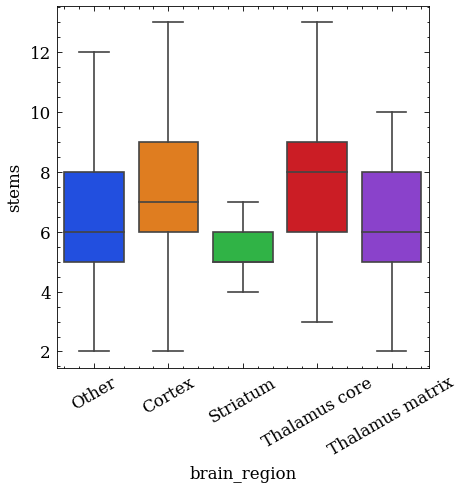

In [74]:
fig=plt.figure(figsize=(4,4),dpi=120)
asmotifs=smotifs.copy()
asmotifs.loc[asmotifs['region'].isin(Th_core_type),'brain_region']= 'Thalamus core'
asmotifs.loc[asmotifs['region'].isin(Th_matrix_type),'brain_region']= 'Thalamus matrix'
sns.boxplot(y='stems', x='brain_region',data=asmotifs,palette="bright",showfliers=False)
plt.xticks(rotation=30,fontsize=10)
plt.show()

size related features: 14 features
1. 通过correlation分析，使用len_min,plen_min,len_mean,contraction_mean4个即可，其他10个feature与这4个相关性都大于0.6
2. Thalamus的平均长度要更大一些，其中Thalamus core在Thalamus中小一些
3. Cortex的弯曲度要更小一点

In [109]:
smotifs[['len_min', 'len_max', 'len_mean','len_median', 'len_std', 'plen_min', 'plen_max', 'plen_mean',
       'plen_median', 'plen_std', 'width', 'height', 'depth','contraction_mean','brain_region']].groupby(['brain_region']).mean()

,len_min,len_max,len_mean,len_median,len_std,plen_min,plen_max,plen_mean,plen_median,plen_std,width,height,depth,contraction_mean
brain_region,,,,,,,,,,,,,,
Cortex,11.985293,124.631689,42.873511,28.827574,39.237831,14.566729,137.690007,47.068698,31.509530,42.990798,83.556793,95.936660,100.557521,0.948100
Other,13.266724,187.367637,62.734944,43.871130,64.056598,16.443997,241.772480,74.797190,46.490801,85.400638,120.232557,133.087018,147.505186,0.923315
Striatum,11.750081,81.430873,34.702810,25.379134,28.321312,12.214073,98.331393,39.609826,27.117993,35.210318,61.097763,68.072276,65.064157,0.893375
Thalamus,10.470350,502.176807,90.000396,23.220323,174.685642,11.724339,718.015821,122.322238,24.357162,254.346572,314.520988,256.367530,375.578792,0.831337


Core shape:  594
Matrix shape:  52


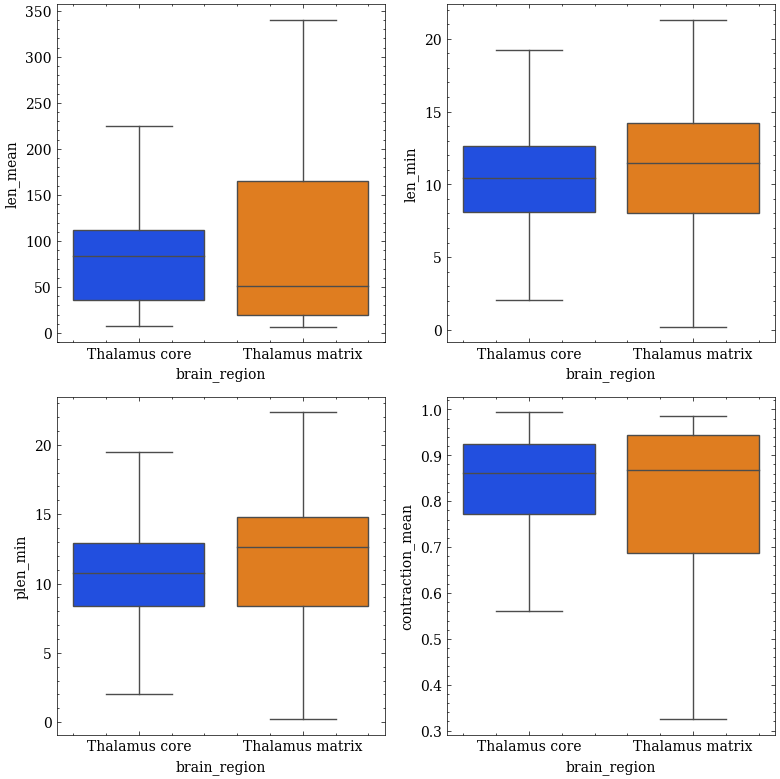

In [107]:
asmotifs=smotifs[['len_min', 'len_max', 'len_mean','len_median', 'len_std', 'plen_min', 'plen_max', 'plen_mean',
       'plen_median', 'plen_std', 'width', 'height', 'depth',
       'contraction_mean','region']].copy()
asmotifs.loc[:,'brain_region']= 'Other'
asmotifs.loc[asmotifs['region'].isin(Th_core_type),'brain_region']= 'Thalamus core'
asmotifs.loc[asmotifs['region'].isin(Th_matrix_type),'brain_region']= 'Thalamus matrix'

print("Core shape: ",asmotifs[asmotifs.brain_region == 'Thalamus core'].shape[0])
print("Matrix shape: ",asmotifs[asmotifs.brain_region == 'Thalamus matrix'].shape[0])
plt.figure(figsize=(8,8),dpi=100)
plt.subplot(221)
sns.boxplot(y='len_mean', x='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],palette="bright",showfliers=False)
# sns.kdeplot(x='angle_min', hue='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(222)
sns.boxplot(y='len_min', x='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],palette="bright",showfliers=False)
# sns.kdeplot(x='angle_mean', hue='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(223)
sns.boxplot(y='plen_min', x='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],palette="bright",showfliers=False)
# sns.kdeplot(x='angle_max', hue='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(224)
sns.boxplot(y='contraction_mean', x='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],palette="bright",showfliers=False)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Ratio (kendall)')

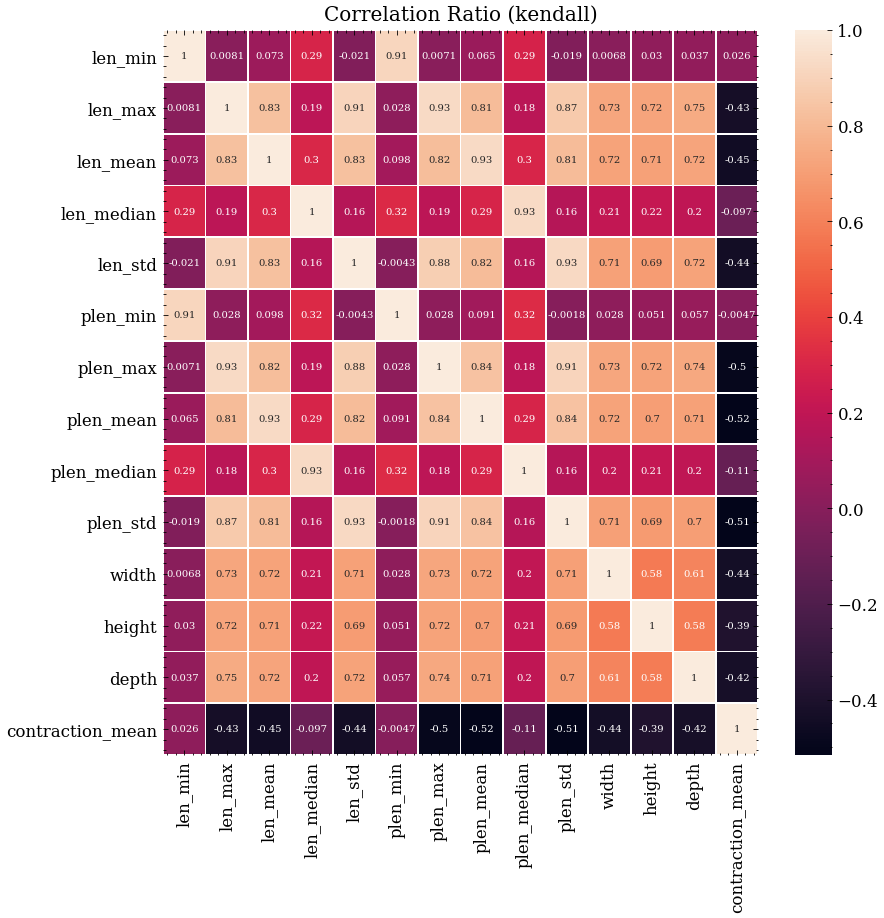

In [114]:
len_corr=asmotifs.drop(['region','brain_region'],axis=1).corr('kendall')
fig=plt.figure(figsize=(8,8),dpi=120)
sns.heatmap(len_corr,linewidth=.5,annot=True,annot_kws={'size':6})
plt.title('Correlation Ratio (kendall)')

Angle features:
   1. no difference in all three brain regions and in one of brain region, which means soma branching angle only have one pattern
   2. angle of core neurons have smaller angle than matrix neurons
   3. angle_mean,angle_std,angle_remote_std can represent angle feature

In [164]:
smotifs[['angle_min', 'angle_max', 'angle_mean','angle_median', 'angle_std','angler_min', 'angler_max', 'angler_mean',
       'angler_median', 'angler_std','brain_region']].groupby(['brain_region']).mean()

,angle_min,angle_max,angle_mean,angle_median,angle_std,angler_min,angler_max,angler_mean,angler_median,angler_std
brain_region,,,,,,,,,,
Cortex,28.657694,154.612186,90.491259,90.552460,35.603918,36.374183,163.363902,98.039825,96.544630,34.653993
Other,32.647648,152.067264,92.511281,93.417770,35.562659,38.728772,158.311365,99.023596,99.280222,34.670569
Striatum,28.714832,148.235855,90.023025,92.499652,37.963365,34.759525,154.980172,96.866327,99.158314,37.475788
Thalamus,19.943581,159.050250,89.438158,90.706207,40.429231,24.103963,160.391867,93.539863,94.874500,38.807880


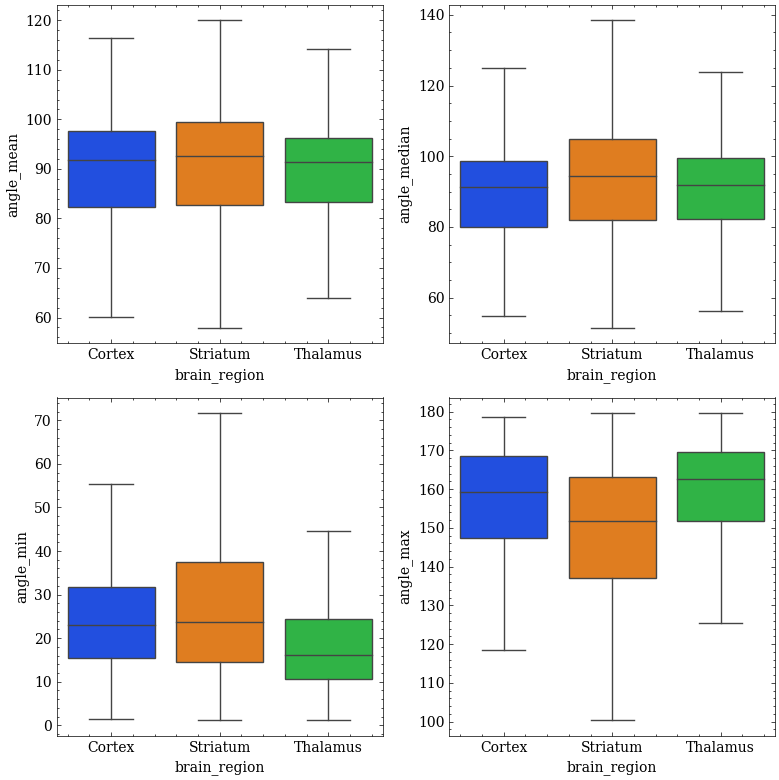

In [165]:
# asmotifs=smotifs[['angle_min', 'angle_max', 'angle_mean',
#        'angle_median', 'angle_std', 'angler_min', 'angler_max', 'angler_mean',
#        'angler_median', 'angler_std', 'region']].copy()
# asmotifs.loc[:,'brain_region']= 'Other'
# asmotifs.loc[asmotifs['region'].isin(Th_core_type),'brain_region']= 'Thalamus core'
# asmotifs.loc[asmotifs['region'].isin(Th_matrix_type),'brain_region']= 'Thalamus matrix'

# print("Core shape: ",asmotifs[asmotifs.brain_region == 'Thalamus core'].shape[0])
# print("Matrix shape: ",asmotifs[asmotifs.brain_region == 'Thalamus matrix'].shape[0])

ssmotifs=smotifs[['angle_min', 'angle_max', 'angle_mean',
       'angle_median', 'angle_std', 'angler_min', 'angler_max', 'angler_mean',
       'angler_median', 'angler_std', 'region','brain_region']].copy()

#2. Thalamus subtypes
# ssmotifs.loc[:,'brain_region']= 'Other'
# ssmotifs.loc[ssmotifs['region'].isin(Th_core_type),'brain_region']= 'Thalamus core'
# ssmotifs.loc[ssmotifs['region'].isin(Th_matrix_type),'brain_region']= 'Thalamus matrix'

#1. three brain regions
# ana_smotifs=smotifs[(smotifs.brain_region != 'Other') & (smotifs.brain_region != 'Cortex') ].copy()
# ana_smotifs=smotifs[(smotifs.brain_region == 'Cortex') ].copy()
asmotifs=ssmotifs[(ssmotifs.brain_region != 'Other')].copy()
# ana_smotifs=ssmotifs[(ssmotifs.region == 'VPM') ].copy()
motif_values=asmotifs.drop(['region','brain_region'],axis=1).values
plt.figure(figsize=(8,8),dpi=100)
plt.subplot(221)
sns.boxplot(y='angle_mean', x='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],palette="bright",showfliers=False)
# sns.kdeplot(x='angle_min', hue='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(222)
sns.boxplot(y='angle_median', x='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],palette="bright",showfliers=False)
# sns.kdeplot(x='angle_mean', hue='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(223)
sns.boxplot(y='angle_min', x='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],palette="bright",showfliers=False)
# sns.kdeplot(x='angle_max', hue='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(224)
sns.boxplot(y='angle_max', x='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],palette="bright",showfliers=False)
# sns.kdeplot(x='angle_std', hue='brain_region',data=asmotifs[asmotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)

plt.tight_layout()
plt.show()

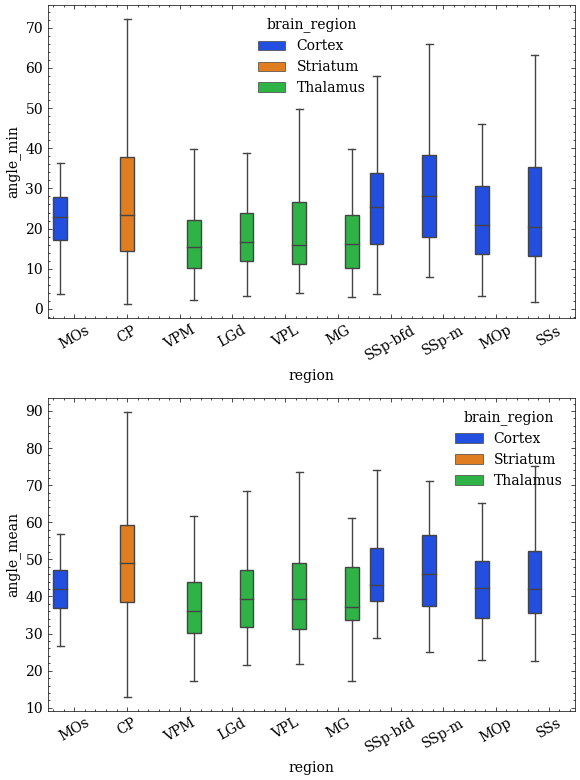

In [30]:
# angle
ana_regions=['VPM','CP','VPL','LGd','SSp-m','MOp','SSs','SSp-bfd','MG','MOs']
plt.figure(figsize=(6,8),dpi=100)
plt.subplot(211)
sns.boxplot(y='angle_min', x='region',hue='brain_region',data=smotifs[(smotifs.brain_region != 'Other')& (smotifs.region.isin(ana_regions))],palette="bright",showfliers=False)
plt.xticks(rotation=30,fontsize=10)
plt.subplot(212)
sns.boxplot(y='angle_mean', x='region',hue='brain_region',data=smotifs[(smotifs.brain_region != 'Other')& (smotifs.region.isin(ana_regions))],palette="bright",showfliers=False)
plt.xticks(rotation=30,fontsize=10)
# plt.subplot(223)
# sns.kdeplot(x='angle_median', hue='brain_region',data=smotifs[smotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
# plt.subplot(224)
# sns.kdeplot(x='angle_std', hue='brain_region',data=smotifs[smotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='angle_mean', ylabel='Count'>

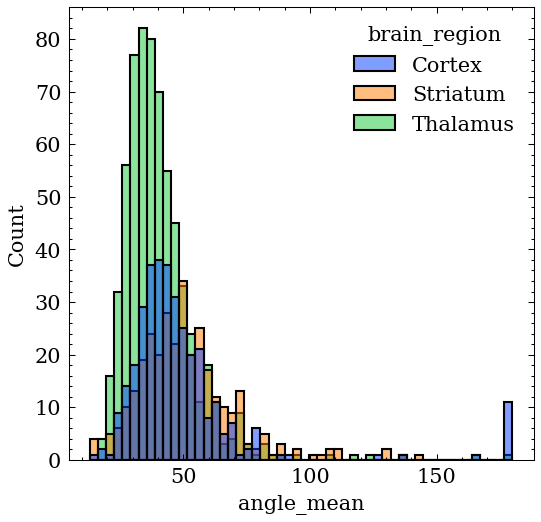

In [38]:
plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
sns.histplot(
   data=smotifs[smotifs.brain_region != 'Other'], x="angle_mean", hue="brain_region",
   fill=True, palette="bright", linewidth=1,
)

In [ ]:
# angle
plt.figure(figsize=(12,4),dpi=100)
plt.subplot(131)
sns.kdeplot(x='angle_mean', hue='brain_region',data=smotifs[(smotifs.brain_region != 'Other')],fill=True, common_norm=False, palette="bright", linewidth=1)
# sns.histplot(x='angle_max', hue='brain_region',data=smotifs[smotifs.brain_region != 'Other'],stat='density', palette="bright",bins=30)
plt.subplot(132)
sns.kdeplot(x='angle_std', hue='brain_region',data=smotifs[smotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(133)
sns.kdeplot(x='angler_std', hue='brain_region',data=smotifs[smotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
# plt.subplot(224)
# sns.kdeplot(x='angle_std', hue='brain_region',data=smotifs[smotifs.brain_region != 'Other'],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.tight_layout()
plt.show()

In [ ]:
# angle in brain_region
ana_bregion='Cortex'
plt.figure(figsize=(12,4),dpi=100)
plt.subplot(131)
sns.kdeplot(x='angle_mean', hue='region',data=smotifs[smotifs.brain_region == ana_bregion],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(132)
sns.kdeplot(x='angle_std', hue='region',data=smotifs[smotifs.brain_region == ana_bregion],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.subplot(133)
sns.kdeplot(x='angler_std', hue='region',data=smotifs[smotifs.brain_region == ana_bregion],fill=True, common_norm=False, palette="bright", linewidth=1)
# plt.subplot(224)
# sns.kdeplot(x='angle_std', hue='region',data=smotifs[smotifs.brain_region == ana_bregion],fill=True, common_norm=False, palette="bright", linewidth=1)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Ratio (kendall)')

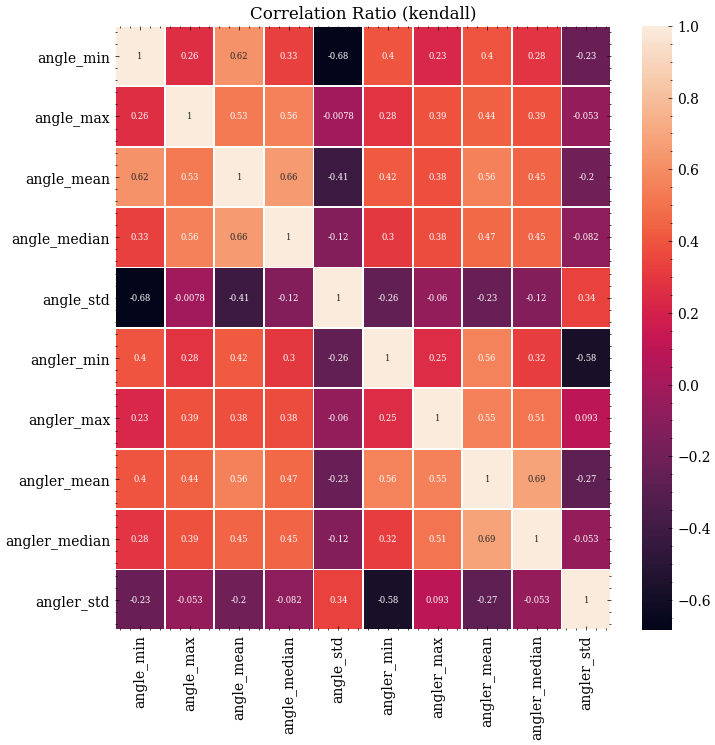

In [116]:
angle_corr=asmotifs.drop(['region','brain_region'],axis=1).corr('kendall')
fig=plt.figure(figsize=(8,8),dpi=100)
sns.heatmap(angle_corr,linewidth=.5,annot=True,annot_kws={'size':6})
plt.title('Correlation Ratio (kendall)')

without type features

In [154]:
smotifs.keys()

Index(['stems', 'stems_axon', 'stems_baselden', 'stems_apicalden',
       'stems_axon_len', 'stems_baselden_len', 'stems_apicalden_len',
       'stems_axon_plen', 'stems_baselden_plen', 'stems_apicalden_plen',
       'width', 'height', 'depth', 'len_mean', 'len_std', 'len_min', 'len_max',
       'plen_mean', 'plen_std', 'plen_min', 'plen_max', 'angle_mean',
       'angle_std', 'angle_min', 'angle_max', 'angle_remote_mean',
       'angle_remote_std', 'angle_remote_min', 'angle_remote_max', 'region',
       'brain_region'],
      dtype='object')

(1321, 29)
Thalamus:  674
Cortex:  329
Striatum:  318


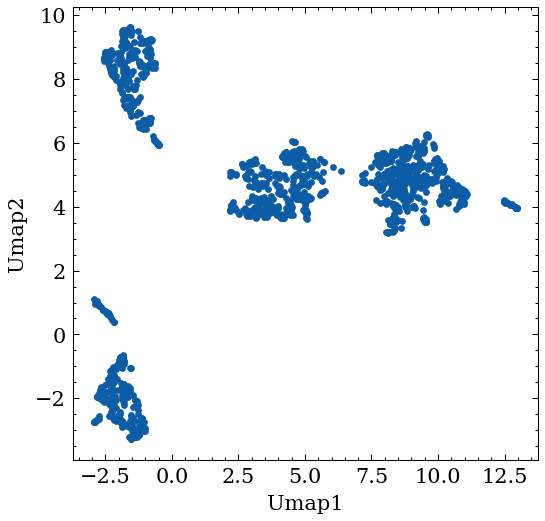

In [9]:
ssmotifs=smotifs.copy()
# ssmotifs=smotifs[['angle_mean', 'angle_std', 'angle_min', 'angle_max',
#        'angle_remote_mean', 'angle_remote_std', 'angle_remote_min',
#        'angle_remote_max', 'region', 'brain_region']].copy()
# ssmotifs=smotifs.drop(['r_mean', 'r_std', 'r_min', 'r_25%', 'r_50%',
#        'r_75%', 'r_max'],axis=1).copy()
# ssmotifs.loc[:,'brain_region']= 'Other'
# ssmotifs.loc[ssmotifs['region'].isin(Th_core_type),'brain_region']= 'Thalamus core'
# ssmotifs.loc[ssmotifs['region'].isin(Th_matrix_type),'brain_region']= 'Thalamus matrix'

# ana_smotifs=smotifs[(smotifs.brain_region != 'Other') & (smotifs.brain_region != 'Cortex') ].copy()
# ana_smotifs=smotifs[(smotifs.brain_region == 'Cortex') ].copy()
ana_smotifs=ssmotifs[(ssmotifs.brain_region != 'Other')].copy()
# ana_smotifs=ssmotifs[(ssmotifs.region == 'CP') ].copy()
motif_values=ana_smotifs.drop(['region','brain_region'],axis=1).values
print(motif_values.shape)
print('Thalamus: ',ana_smotifs[ana_smotifs.brain_region =='Thalamus'].shape[0])
print('Cortex: ',ana_smotifs[ana_smotifs.brain_region =='Cortex'].shape[0])
print('Striatum: ',ana_smotifs[ana_smotifs.brain_region =='Striatum'].shape[0])
motif_s=StandardScaler().fit_transform(motif_values)
embedding = umap.UMAP(n_neighbors=10,min_dist=0,random_state=3).fit_transform(motif_s)
ana_smotifs['umap1']=embedding[:,0]
ana_smotifs['umap2']=embedding[:,1]
# level_motif['umap3']=level_embedding[:,2]

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
# plt.title('Cortex')
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.show()

<AxesSubplot:>

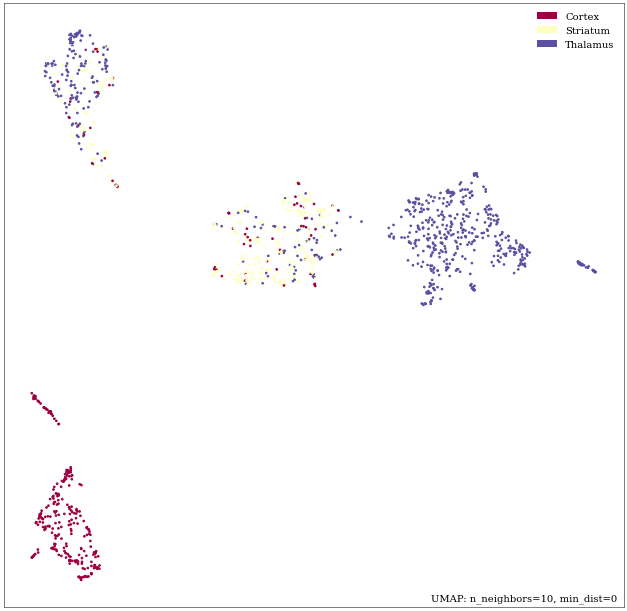

In [10]:
mapper = umap.UMAP(n_neighbors=10,min_dist=0,random_state=3).fit(motif_s)
umap.plot.points(mapper,labels=ana_smotifs['brain_region'])

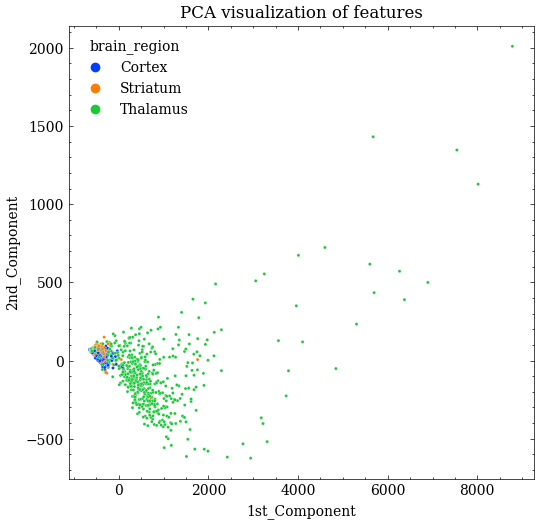

In [348]:
from sklearn.decomposition import PCA   #导入PCA
X_pca = PCA(n_components=2).fit_transform(motif_values)   
# n_components为PCA的参数，所要保留的主成分个数n，也即保留下来的特征个数n
# train_x_fea为需要降维的数据
ana_smotifs['1st_Component']=X_pca[:,0]
ana_smotifs['2nd_Component']=X_pca[:,1]
# X_pca = np.vstack((X_pca.T, level_motif['llabel'])).T  #把降维后的数据和标签按垂直方向（行顺序）堆叠数组构成一个新的数组
# df_pca = pd.DataFrame(X_pca, columns=['1st_Component','2nd_Component','label'],index=level_motif.index)   #把降维后的数据和标签进行组合
# df_pca.head()
plt.figure(figsize=(6, 6),dpi=100)  #定义输出图像大小
sns.scatterplot(data=ana_smotifs, hue='brain_region',x='1st_Component',y='2nd_Component',s=5,palette='bright')   #画散点图，定义X/Y轴
plt.rcParams['xtick.direction'] = 'in'  #plt.rcParams主要作用是设置画的图的分辨率，大小等信息
plt.rcParams['ytick.direction'] = 'in'
plt.title('PCA visualization of features')  #定义标题
# plt.savefig('PCA visualization of features.jpg')  #保存图片
# plt.ylim([-200,300])
# plt.xlim([-200,300])
plt.show()

with type features

(1705, 29)
Thalamus:  925
Cortex:  427
Striatum:  353


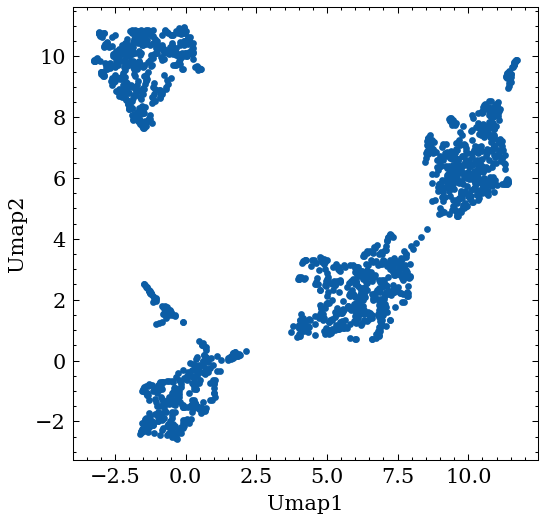

In [6]:
ssmotifs=smotifs.copy()
# ssmotifs.loc[:,'brain_region']= 'Other'
# ssmotifs.loc[ssmotifs['region'].isin(Th_core_type),'brain_region']= 'Thalamus core'
# ssmotifs.loc[ssmotifs['region'].isin(Th_matrix_type),'brain_region']= 'Thalamus matrix'

# ana_smotifs=smotifs[(smotifs.brain_region != 'Other') & (smotifs.brain_region != 'Cortex') ].copy()
# ana_smotifs=smotifs[(smotifs.brain_region == 'Cortex') ].copy()
ana_smotifs=ssmotifs[(ssmotifs.brain_region != 'Other')].copy()
# ana_smotifs=ssmotifs[(ssmotifs.region == 'VPM') ].copy()
motif_values=ana_smotifs.drop(['region','brain_region'],axis=1).values
print(motif_values.shape)
print('Thalamus: ',ana_smotifs[ana_smotifs.brain_region =='TH'].shape[0])
print('Cortex: ',ana_smotifs[ana_smotifs.brain_region =='CTX'].shape[0])
print('Striatum: ',ana_smotifs[ana_smotifs.brain_region =='CNU'].shape[0])
motif_s=StandardScaler().fit_transform(motif_values)
embedding = umap.UMAP(n_neighbors=10,random_state=3).fit_transform(motif_s)
ana_smotifs['umap1']=embedding[:,0]
ana_smotifs['umap2']=embedding[:,1]
# level_motif['umap3']=level_embedding[:,2]

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
plt.scatter(embedding[:, 0], embedding[:, 1], s=5)
# plt.title('Cortex')
plt.xlabel('Umap1')
plt.ylabel('Umap2')
plt.show()

<AxesSubplot:>

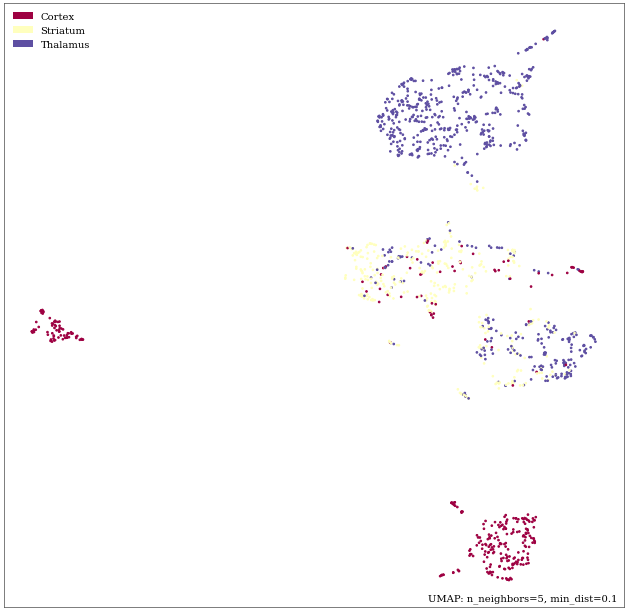

In [78]:
mapper = umap.UMAP(n_neighbors=5,random_state=3).fit(motif_s)
umap.plot.points(mapper,labels=ana_smotifs['brain_region'])

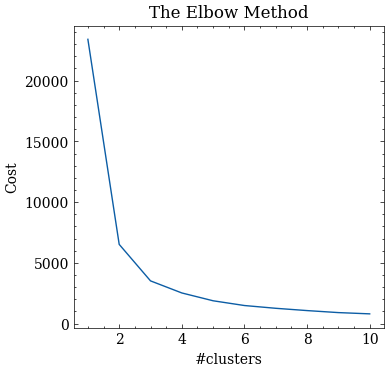

In [275]:
cost = []#初始化损失（距离）值
for i in range(1,11):#尝试不同的K值
    kmeans = KMeans(n_clusters= i ,init='k-means++', random_state =3)
    kmeans.fit(embedding)
    cost.append(kmeans.inertia_)#inerita_是我们选择的方法，其作用相当于损失函数

fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
plt.plot(range(1,11),cost)
plt.title('The Elbow Method')
plt.ylabel('Cost')
plt.xlabel('#clusters')
plt.show()

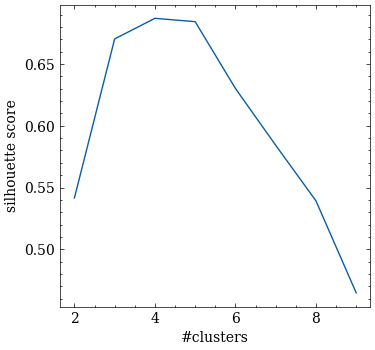

In [8]:
from sklearn.metrics import silhouette_score
cost = []#初始化损失（距离）值
for i in range(2,10):#尝试不同的K值
    kmeans = KMeans(n_clusters= i ,init='k-means++', random_state =3)
    kmeans.fit(embedding)
    sc_score = silhouette_score(embedding, kmeans.labels_, metric="euclidean")
    cost.append(sc_score)#inerita_是我们选择的方法，其作用相当于损失函数

fig=plt.figure(figsize=(4,4),dpi=100)
plt.subplot(111)
plt.plot(range(2,10),cost)
# plt.title('轮廓系数')
plt.ylabel('silhouette score')
plt.xlabel('#clusters')
plt.show()

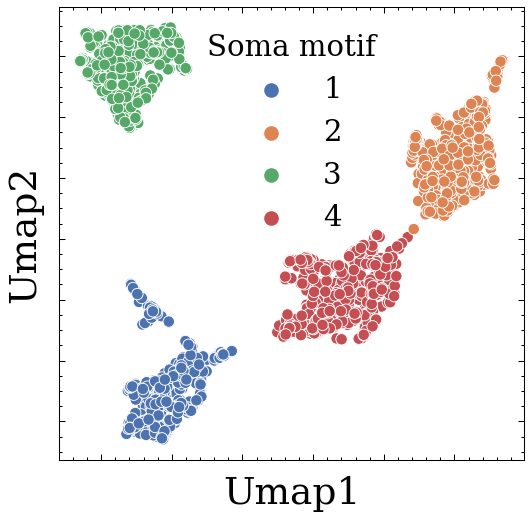

save tiff : ./soma_motif_figs/motif_clustering.tiff


In [7]:
#Kmeans-clustering
# from cProfile import label
kclusters=4
kmeansmodel = KMeans(n_clusters=kclusters,init='k-means++',random_state=3)
kmeansmodel.fit(embedding)
centers = kmeansmodel.cluster_centers_
ana_smotifs['Motif']=(kmeansmodel.labels_+1)
# axon_motif['region']=axon_motif_labels['motif_region']

fig=plt.figure(figsize=(4,4),dpi=150)
plt.subplot(111)
# color=['blue','green']
# mypalette=sns.color_palette(color)
sns.scatterplot(data=ana_smotifs,x='umap1',y='umap2',hue='Motif',s=30,palette='deep')
# colors = np.array(['red','blue'])
# plt.scatter(embedding[:, 0], embedding[:, 1], c = colors[ana_smotifs['Motif']-1], s = 5)
# plt.scatter(centers[0, 0], centers[0, 1],s = 4, c = 'red', alpha=0.5,label = 'Cluster 1')#聚类1
# plt.scatter(centers[1, 0], centers[1, 1],s = 4, c = 'green',alpha=0.5, label = 'Cluster 2')#聚类2
# plt.scatter(centers[2, 0], centers[2, 1],s = 4, c = 'blue',alpha=0.5, label = 'Cluster 3')#聚类3
# plt.legend()
ax = plt.gca()

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# plt.grid(True)
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=14,title_fontsize=14,title='Soma motif')

# plt.tick_params(labelsize=14)
plt.xlabel('Umap1',fontsize=18)
plt.ylabel('Umap2',fontsize=18)
# plt.title('Clustering of Thalamus data (Kmeans)')
# plt.title('Clustering of soma motif')
plt.show()

savefile=figcenter+'motif_clustering.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

In [29]:
multi_level_smotif=ana_smotifs['Motif'].copy()
multi_level_smotif.to_csv('../../cross_level/ana_soma_motif_fea.csv')

['VPM', 'CP', 'VPL', 'LGd', 'SSp-m', 'MOp', 'SSs', 'SSp-bfd', 'MOs', 'MG']


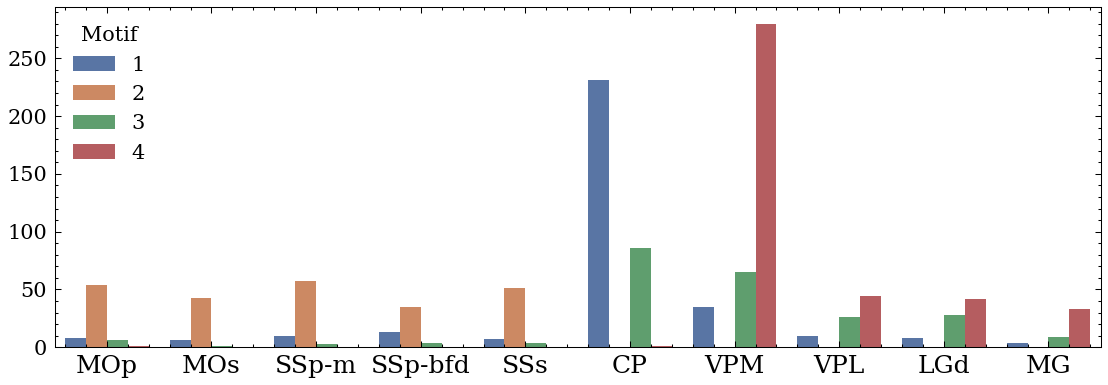

save tiff : ./soma_motif_figs/motif_dist_in_soma_region.tiff


In [153]:
print(ana_smotifs['region'].value_counts().head(10).keys().tolist())
tregions=['MOp', 'MOs','SSp-m', 'SSp-bfd','SSs','CP','VPM', 'VPL', 'LGd','MG']

fig=plt.figure(figsize=(9,3),dpi=150)
plt.subplot(111)
sns.countplot(x='region',hue='Motif',data=ana_smotifs[ana_smotifs.region.isin(tregions)],palette='deep',order=tregions)
plt.xticks(rotation=0,fontsize=12)
# plt.xlabel('Soma region',fontsize=12)
# plt.ylabel('# of motifs',fontsize=12)
plt.xlabel('')
plt.ylabel('')
# plt.legend(fontsize=12)
# plt.title('Soma motif distribution',fontsize=12)
plt.show()

savefile=figcenter+'motif_dist_in_soma_region.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

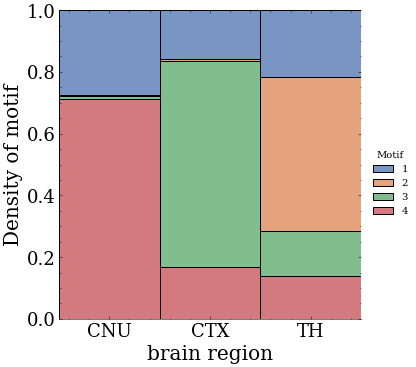

In [12]:
# fig=plt.figure(figsize=(4,4),dpi=150)
# plt.subplot(111)
# sns.countplot(x='brain_region',hue='Motif',data=ana_smotifs,palette='deep')
g=sns.displot(x='brain_region',hue='Motif',data=ana_smotifs,palette='deep',
            multiple="fill",common_norm=False,
            legend=True)
# sns.displot(penguins, x="flipper_length_mm", hue="species", stat="density", common_norm=False)
# sns.move_legend(g, "upper left",bbox_to_anchor=(.2, .95),fontsize=18,title="Soma motif",title_fontsize=16)
# g.add_legend([1,2,3,4])
g.set_xticklabels(fontsize=18)
g.set_yticklabels(fontsize=18)
g.set_xlabels('brain region',fontsize=20)
g.set_ylabels('Density of motif',fontsize=20)
# savefile=figcenter+'motif_dist_in_brain_region.png'
# g.savefig(savefile,dpi=300)
# Img2TIFF(savefile,compression='lzw')
# plt.xticks(rotation=0,fontsize=14)
# plt.xlabel('Brain region')
# plt.ylabel('Count')
# plt.title('Motif distribution',fontsize=13)
# plt.xlabel('')
# plt.ylabel('')
# plt.legend(fontsize=14)
# plt.tick_params(labelsize=20)
# plt.show()


# savefile=figcenter+'motif_dist_in_brain_region.png'
# fig.savefig(savefile,dpi=300)
# Img2TIFF(savefile,compression='lzw')

['Motif4:18454_00146', 'Motif4:18454_01072', 'Motif4:18457_00204', 'Motif4:18463_00066', 'Motif4:18454_01104', 'Motif4:18454_01064', 'Motif4:18462_00017', 'Motif4:18463_00015']


(<Figure size 4000x500 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Motif4:18454_00146'}, xlabel='X', ylabel='Y'>,
        <AxesSubplot:title={'center':'Motif4:18454_01072'}, xlabel='X', ylabel='Y'>,
        <AxesSubplot:title={'center':'Motif4:18457_00204'}, xlabel='X', ylabel='Y'>,
        <AxesSubplot:title={'center':'Motif4:18463_00066'}, xlabel='X', ylabel='Y'>,
        <AxesSubplot:title={'center':'Motif4:18454_01104'}, xlabel='X', ylabel='Y'>,
        <AxesSubplot:title={'center':'Motif4:18454_01064'}, xlabel='X', ylabel='Y'>,
        <AxesSubplot:title={'center':'Motif4:18462_00017'}, xlabel='X', ylabel='Y'>,
        <AxesSubplot:title={'center':'Motif4:18463_00015'}, xlabel='X', ylabel='Y'>],
       dtype=object))

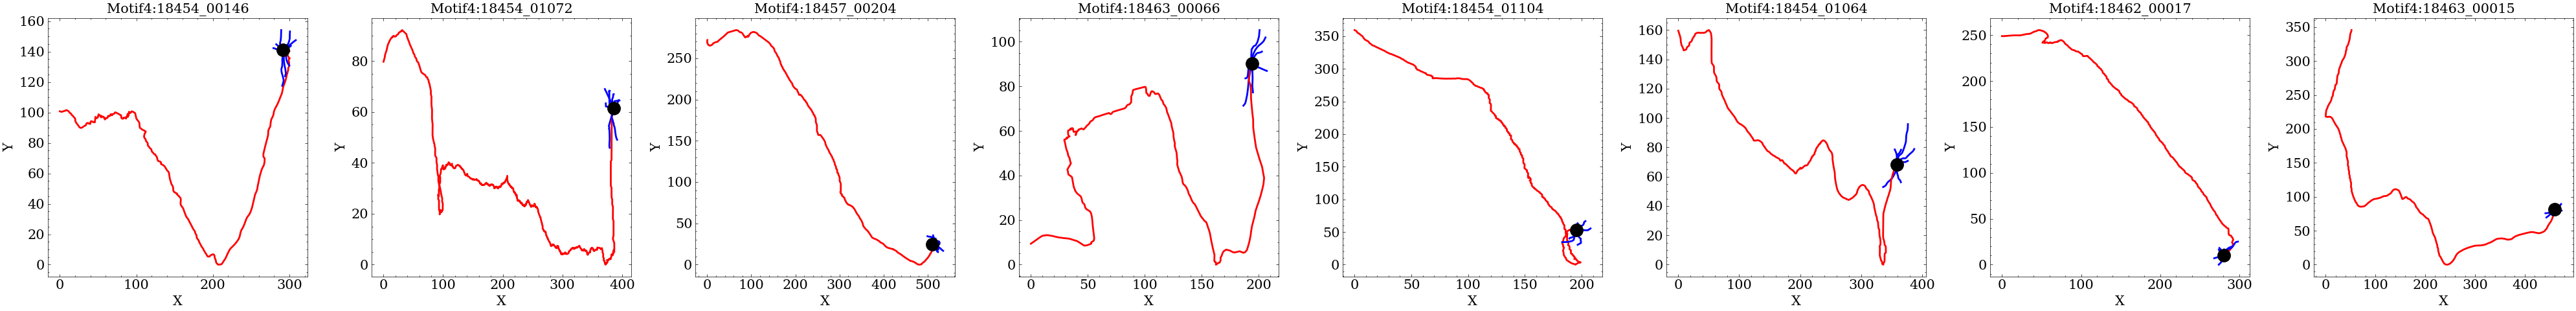

In [35]:
ana_motif=4
mdis1=0.1
sbrpath='../motif/soma/soma_motif_swc'
center_motifs=[]
ctitles=[]
for dis in np.arange(1,20):
    mdis=mdis1*dis
    cmotifs=ana_smotifs[(ana_smotifs.Motif==ana_motif) 
            & (abs(ana_smotifs.umap1 - centers[ana_motif-1,0])<mdis) 
            & (abs(ana_smotifs.umap2 - centers[ana_motif-1,1])<mdis)]
    if cmotifs.shape[0] > 8:
        # print('0 shape of cluster',nc)
        break
for motif in cmotifs.index:
    center_motif_path=os.path.join(sbrpath,motif.split('.eswc')[0]+'.swc')
    if len(center_motifs)>=8:
        break
    if os.path.exists(center_motif_path):
        center_motifs.append(center_motif_path)
        ctitles.append('Motif'+str(ana_motif)+':'+motif.split('.eswc')[0])
print(ctitles)
motifs_plot(center_motifs,title=ctitles,fontsize=15,compare=-1,linewidth=2,direction='XY')


In [25]:
print(ctitles)

['Motif1: 26.6%', 'Motif2: 24.8%', 'Motif3: 21.3%', 'Motif4: 27.3%']


['Motif1: 26.6%', 'Motif2: 24.8%', 'Motif3: 21.3%', 'Motif4: 27.3%']
save tiff : ./soma_motif_figs/motifs.tiff


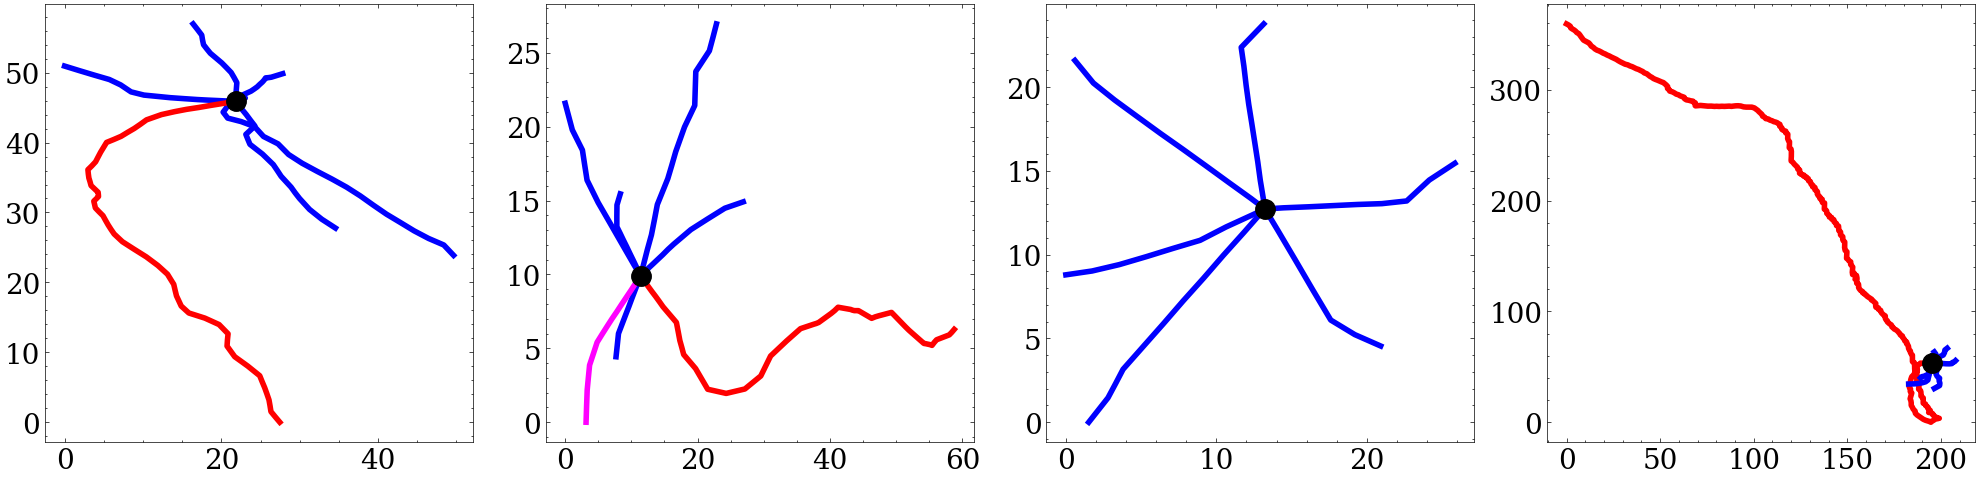

In [36]:
sbrpath='../motif/soma/soma_motif_swc'
preset_motifs=['17545_00132','18453_2645_x28684_y11703','18454_01048','18454_01104']
center_motifs=[]
ctitles=[]
for pi,pm in enumerate(preset_motifs):
    center_motif_path=os.path.join(sbrpath,pm+'.swc')
    motif_num=round(100*ana_smotifs[(ana_smotifs.Motif==(pi+1))].shape[0]/ana_smotifs[(ana_smotifs.Motif>=1)].shape[0],1)
    if os.path.exists(center_motif_path):
        center_motifs.append(center_motif_path)
        ctitles.append('Motif'+str(pi+1)+': '+str(motif_num)+'%')
# print(center_motif_path)
print(ctitles)
fig,ax=motifs_plot(center_motifs,compare=-1,linewidth=4,direction='XY',xylabel=False,fontsize=20)
# fig,ax=motifs_plot(center_motifs,title=ctitles,fontsize=20,compare=-1,linewidth=4,direction='XY',xylabel=False)
savefile=figcenter+'motifs.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

(<Figure size 2000x500 with 4 Axes>, <AxesSubplot:title={'center':'Motif4'}>)

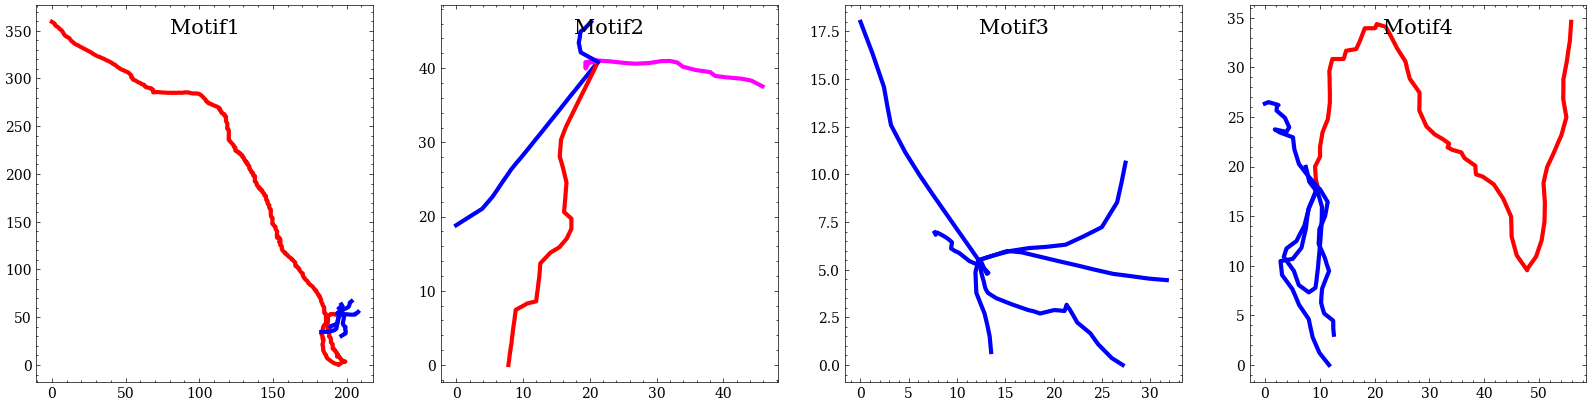

In [78]:
sbrpath='../motif/soma/soma_motif_swc'
mdis1=0.2
center_motifs=[]
ctitles=[]

for nc in np.arange(1,kclusters+1):
    cmotifs=ana_smotifs[(ana_smotifs.Motif==nc) 
        & (abs(ana_smotifs.umap1 - centers[nc-1,0])<mdis1) 
        & (abs(ana_smotifs.umap2 - centers[nc-1,1])<mdis1)]
    if cmotifs.shape[0] == 0:
        break
    center_motif_path=os.path.join(sbrpath,cmotifs.index.to_list()[3].split('.eswc')[0]+'.swc')
    if os.path.exists(center_motif_path):
        center_motifs.append(center_motif_path)
        ctitles.append('Motif'+str(nc))
motifs_plot(center_motifs,title=ctitles,fontsize=15,compare=-1,linewidth=3,direction='XY',xylabel=False)

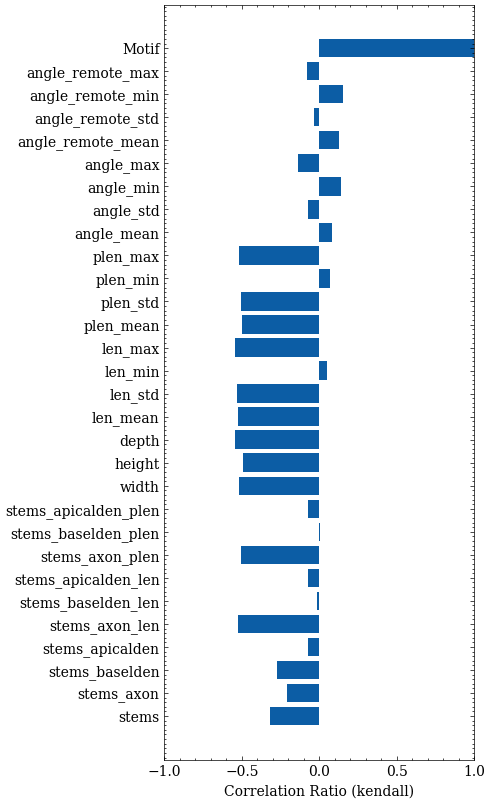

In [57]:
corr=ana_smotifs.drop(['umap1','umap2','region','brain_region'],axis=1).corr('kendall')

# corr.drop(['umap1','umap2'],axis=1,inplace=True)
# print(corr['Kmeans'].sort_values())
fig=plt.figure(figsize=(4,10),dpi=100)
plt.subplot(111)
# corr=corr[(corr.Cluster>0.5)| (corr.Cluster<-0.5)].copy()
plt.barh(y=corr.index.to_list(),width=corr['Motif'].to_list())
plt.xlim([-1,1])
# plt.xlabel('Correlation Ratio (pearson)')
plt.xlabel('Correlation Ratio (kendall)')
plt.show()

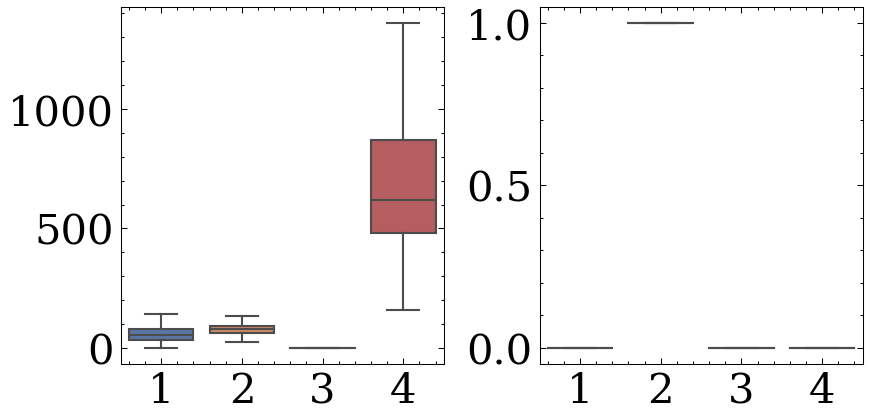

save tiff : ./soma_motif_figs/motif_fea_key.tiff


In [22]:
mypalette='deep'
fig=plt.figure(figsize=(6,3),dpi=150)
plt.subplot(121)
sns.boxplot(y='stems_axon_len', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
# plt.yscale('log')
# plt.ylim([-5,2000])
# plt.ylabel('Axonal stem length (um)',fontsize=12)
plt.tick_params(labelsize=20)
plt.ylabel('')
plt.xlabel('')

plt.subplot(122)
sns.boxplot(y='stems_apicalden', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
# plt.ylabel('# of apical dendrites',fontsize=12)
plt.ylabel('')
plt.xlabel('')
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.show()


savefile=figcenter+'motif_fea_key.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')

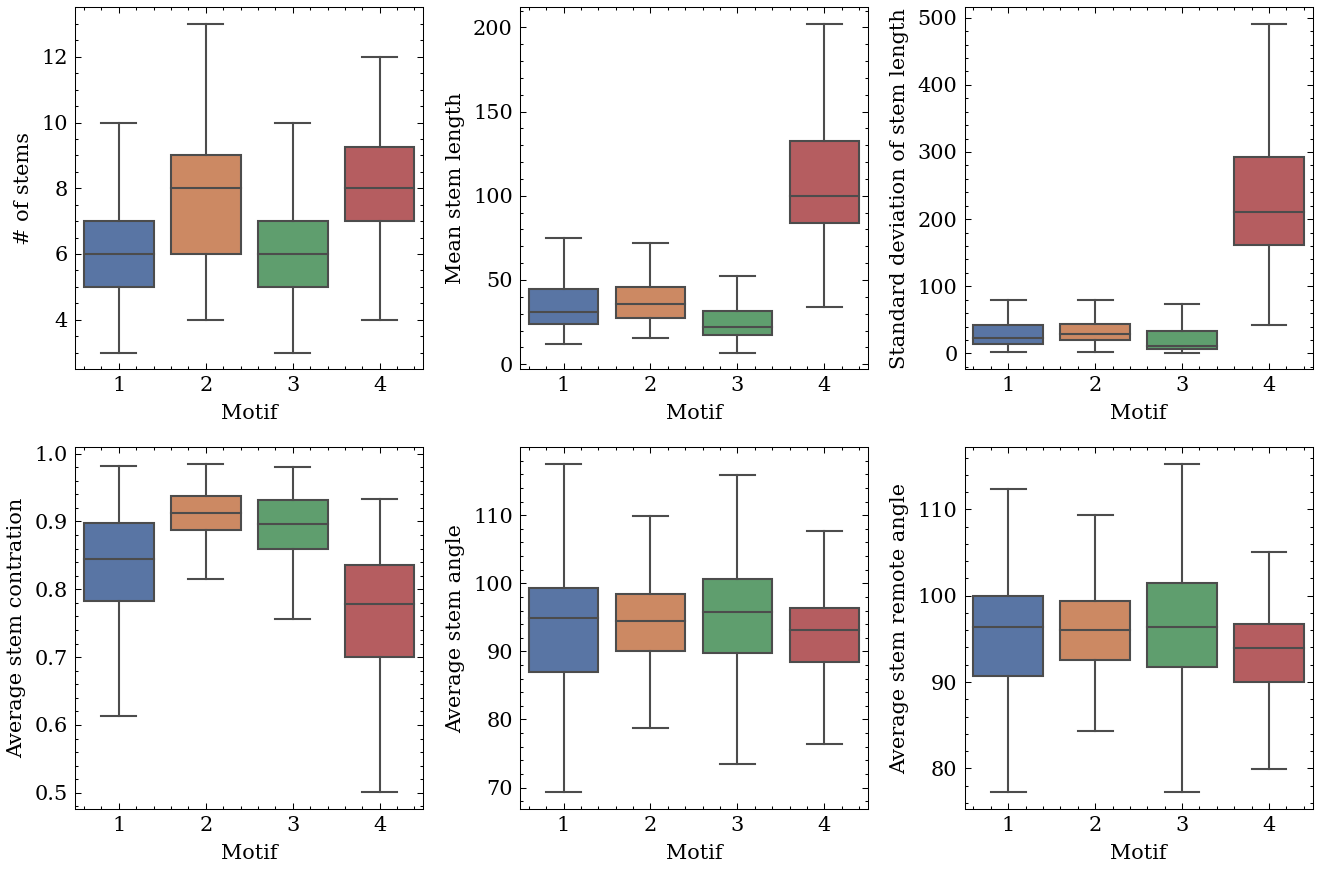

save tiff : ./soma_motif_figs/motif_feas.tiff


In [145]:
'''
# stem, len_mean, len_std, contraction_mean, angle_mean, angle_remote_mean
'''
mypalette='deep'
fig=plt.figure(figsize=(9,6),dpi=150)
plt.subplot(231)
sns.boxplot(y='stems', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('# of stems',fontsize=10)
plt.subplot(232)
sns.boxplot(y='len_mean', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('Mean stem length',fontsize=10)
plt.subplot(233)
sns.boxplot(y='len_std', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('Standard deviation of stem length',fontsize=10)
ana_smotifs['contraction']=ana_smotifs['len_mean']/ana_smotifs['plen_mean']
plt.subplot(234)
sns.boxplot(y='contraction', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('Average stem contration',fontsize=10)
plt.subplot(235)
sns.boxplot(y='angle_mean', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('Average stem angle',fontsize=10)
plt.subplot(236)
sns.boxplot(y='angle_remote_mean', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('Average stem remote angle',fontsize=10)
plt.tight_layout()
plt.show()


savefile=figcenter+'motif_feas.png'
fig.savefig(savefile,dpi=300)
Img2TIFF(savefile,compression='lzw')
# plt.subplot(223)
# sns.boxplot(y='angle_io1', x='Cluster',data=level_motif,showfliers=False)

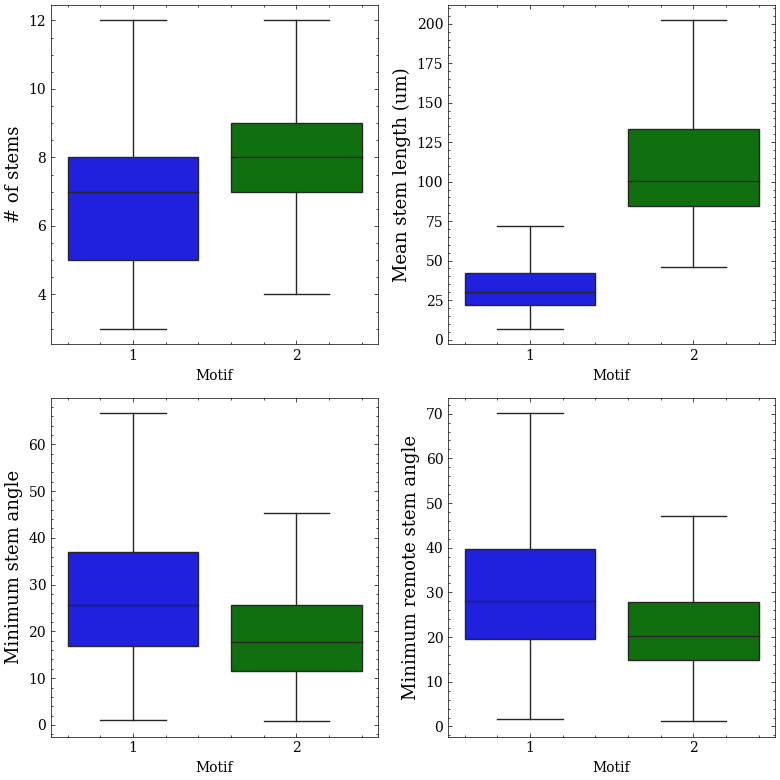

In [946]:
plt.figure(figsize=(8,8),dpi=100)
plt.subplot(221)
sns.boxplot(y='stems', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('# of stems',fontsize=13)
plt.subplot(222)
sns.boxplot(y='len_mean', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('Mean stem length (um)',fontsize=13)
plt.subplot(223)
sns.boxplot(y='angle_min', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('Minimum stem angle',fontsize=13)
plt.subplot(224)
sns.boxplot(y='angle_remote_min', x='Motif',data=ana_smotifs,showfliers=False,palette=mypalette)
plt.ylabel('Minimum remote stem angle',fontsize=13)
plt.tight_layout()
plt.show()
# plt.subplot(223)
# sns.boxplot(y='angle_io1', x='Cluster',data=level_motif,showfliers=False)

In [837]:
motif1.keys()

Index(['stems', 'width', 'height', 'depth', 'len_mean', 'len_std', 'len_min',
       'len_max', 'plen_mean', 'plen_std', 'plen_min', 'plen_max', 'L_angle1',
       'L_angle2', 'L_angle3', 'L_angle4', 'L_angle5', 'L_angle6', 'R_angle1',
       'R_angle2', 'R_angle3', 'R_angle4', 'R_angle5', 'R_angle6', 'region',
       'brain_region', 'umap1', 'umap2', 'Motif'],
      dtype='object')

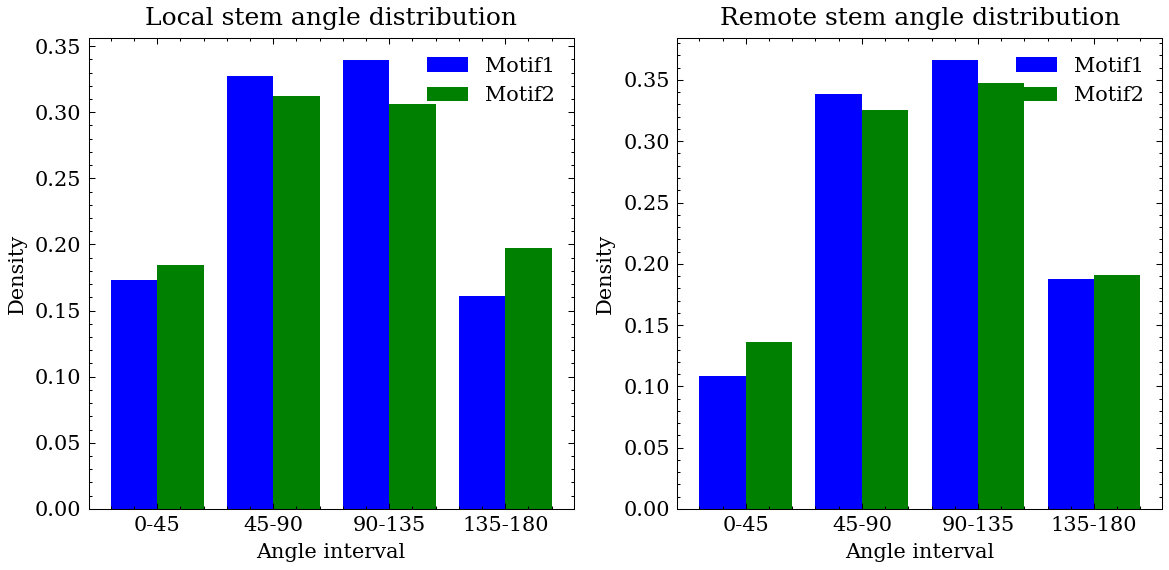

In [884]:
plt.figure(figsize=(8,4),dpi=150)
plt.subplot(121)
motif1=ana_smotifs[ana_smotifs.Motif==1].copy()
L1=motif1[['L_angle1','L_angle2', 'L_angle3', 'L_angle4']].mean().values
R1=motif1[['R_angle1','R_angle2', 'R_angle3', 'R_angle4']].mean().values
motif2=ana_smotifs[ana_smotifs.Motif==2].copy()
L2=motif2[['L_angle1','L_angle2', 'L_angle3', 'L_angle4']].mean().values
R2=motif2[['R_angle1','R_angle2', 'R_angle3', 'R_angle4']].mean().values
plt.bar(x=np.arange(4)-0.2,height=L1,label='Motif1',width=0.4,color='blue')
plt.bar(x=np.arange(4)+0.2,height=L2,label='Motif2',width=0.4,color='green')
plt.xticks(np.arange(4), ('0-45', '45-90', '90-135', '135-180')) 
# plt.xticks(rotation=30,fontsize=10)
plt.xlabel('Angle interval')
plt.ylabel('Density')
plt.title('Local stem angle distribution')
plt.legend()

plt.subplot(122)
plt.bar(x=np.arange(4)-0.2,height=R1,label='Motif1',width=0.4,color='blue')
plt.bar(x=np.arange(4)+0.2,height=R2,label='Motif2',width=0.4,color='green')
plt.xticks(np.arange(4), ('0-45', '45-90', '90-135', '135-180')) 
# plt.xticks(rotation=30,fontsize=10)
plt.xlabel('Angle interval')
plt.ylabel('Density')
plt.title('Remote stem angle distribution')
plt.legend()
plt.tight_layout()
plt.show()